# Mandatory Assignment 3 DAT200 NMBU 2025

In [1]:
# Import necessary libraries
import sklearn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score

## 1. Load the dataset and explore it

In [2]:
train_df = pd.read_csv('assets/train.csv')
test_df = pd.read_csv('assets/test.csv')
train_df.head()

,Size,Weight,Sweetness,Softness,HarvestTime,Ripeness,Acidity,Peel Thickness,Banana Density,Quality
0,-1.825734,-0.883754,-2.423530,-1.198136,-4.286523,1.585792,-0.589002,0.164434,65822.758426,0
1,-0.142286,-0.708374,-2.224219,2.222650,1.896814,-4.284821,1.069387,0.704945,99930.329162,0
2,-1.957254,-4.293733,-1.073703,-1.405019,-0.729812,3.930497,-0.397840,0.852810,37081.567982,0
3,-2.168043,3.095472,1.707717,-0.584218,-0.564767,0.014740,-0.103799,0.582909,63931.435551,1
4,-3.149338,3.058402,2.173671,-0.265609,-2.563220,0.376015,1.434252,0.102162,48711.448819,1


In [3]:
train_df.info(), test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2800 entries, 0 to 2799
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Size            2800 non-null   float64
 1   Weight          2800 non-null   float64
 2   Sweetness       2800 non-null   float64
 3   Softness        2800 non-null   float64
 4   HarvestTime     2800 non-null   float64
 5   Ripeness        2800 non-null   float64
 6   Acidity         2800 non-null   float64
 7   Peel Thickness  2800 non-null   float64
 8   Banana Density  2800 non-null   float64
 9   Quality         2800 non-null   int64  
dtypes: float64(9), int64(1)
memory usage: 218.9 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1200 entries, 0 to 1199
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Size            1200 non-null   float64
 1   Weight          1200 non-null   float64
 2   Sweetness 

(None, None)

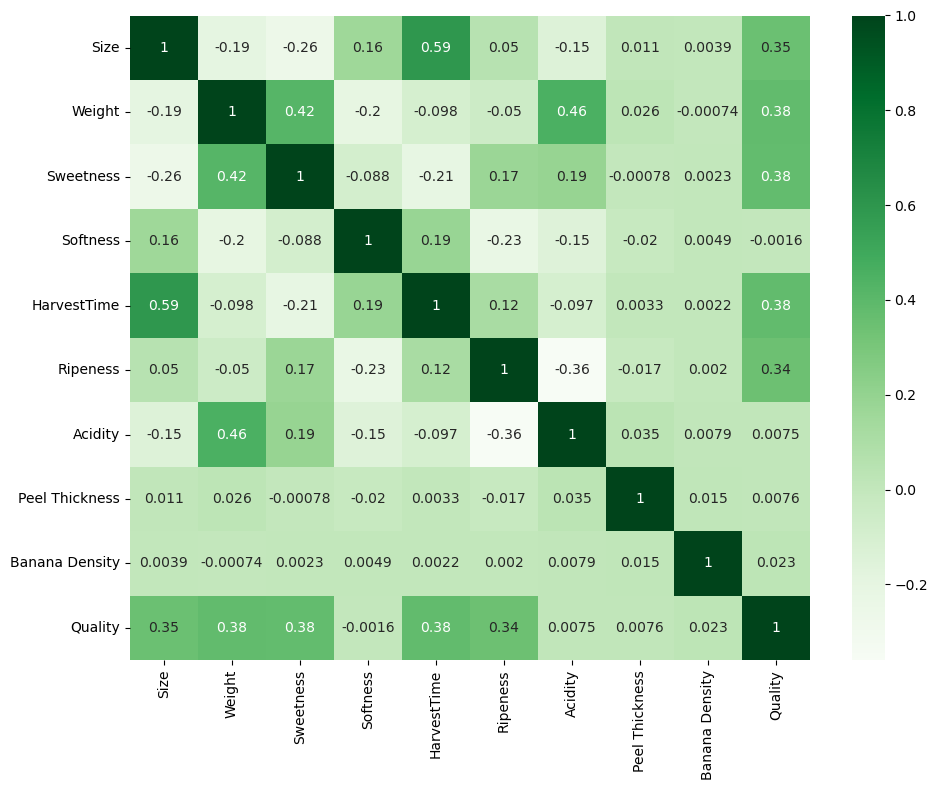

In [4]:
# make a confusion matrix
matrix = train_df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(matrix, cmap="Greens", annot=True)
plt.tight_layout()
plt.show()

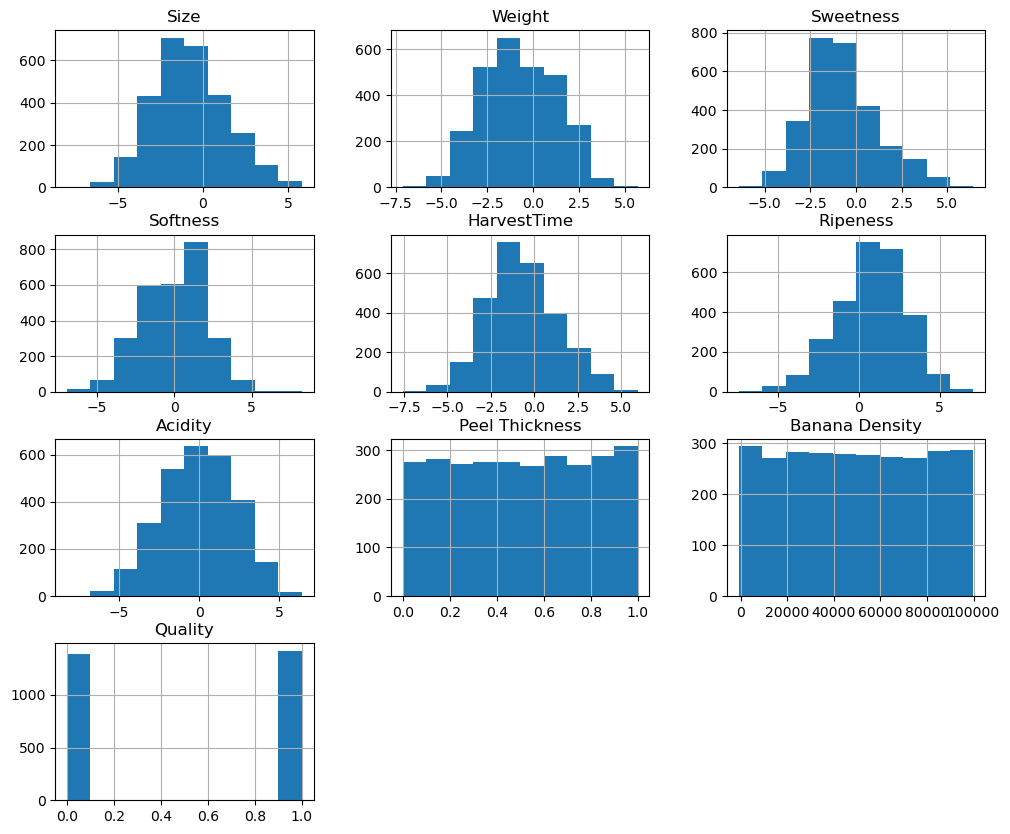

In [5]:
train_df.hist(figsize=(12, 10));

Looking it at the correlation matrix, it seems some columns are contributing more then others. Therefore we'll try to add features and possible drop some. But first we'll get a benchmark for accuracy

In [6]:
"""
Add squared and interaction features to emphasize their importance and capture non-linear effects.
Drop columns with low correlation to reduce noise and improve model focus.
"""

def add_features(df):
    df = df.copy()
    df = df.drop(['Peel Thickness', 'Banana Density'], axis=1)
    df['feature1'] = (df['Ripeness'] * df['Softness']) / df['HarvestTime']
    df['feature2'] = df['Ripeness'] - df['HarvestTime']
    df['feature3'] = df['Ripeness'] / df['Softness']
    df['feature4'] = df['Softness'] ** 2
    df['feature5'] = df['HarvestTime'] / df['Ripeness']
    return df

pipeline = Pipeline([
    ('feature_engineering', FunctionTransformer(add_features)),
    ('scaler', StandardScaler())
])

In [7]:
X = train_df.drop('Quality', axis=1)
y = train_df['Quality']

# Split into training and test sets.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the pipeline on training data and transform both train and test.
X_train_scaled = pipeline.fit_transform(X_train)
X_test_scaled = pipeline.transform(X_test)

In [8]:
""" 
running a small gridsearch on SVC, in the "real" gridsearch we used other models to and more paramters. We used a server
to run the gridsearch which means we couldn't use jupyter as we only had access to the terminal. therefore we had to cut it down
here for the submission so it would use so long to run.  
""" 

param_grid = {
    'C': [0.1, 1, 5, 10],
    'gamma': ['scale', 'auto', 0.01, 0.1, 1],
    'kernel': ['rbf', 'linear']
}

model = SVC()
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='f1_macro', n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)

# Printing the best parameters
print("Beste parametere: ", grid_search.best_params_)

Beste parametere:  {'C': 1, 'gamma': 1, 'kernel': 'rbf'}


In [9]:
# Using best model to predict on test set
y_pred = grid_search.best_estimator_.predict(X_test_scaled)

accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')
print(f'Accuracy: {accuracy}, F1: {f1}')

Accuracy: 0.9714285714285714, F1: 0.9714285714285714


In [10]:
scaled_test_df = pipeline.transform(test_df)

y_test = grid_search.best_estimator_.predict(scaled_test_df)
y_test = pd.DataFrame(y_test, columns=["Quality"])
y_test.index.name = "ID"
y_test[['Quality']].to_csv("submission.csv")
